<center><h1>McGill University - <b>ECSE 415</b> Introduction to Computer Vision</h1>
<h2><b>Assignment 4 </b>Neural Networks</h2>
<h4>@author: Alex Wei &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; @version: 2.0.1</h4></center>

\
\
\
##**! README !**
1. Double Pound Signs in this notebook indicate adaptive snippets between running locally (Python 3.12.0) and on Colab. (Un)comment & adjust before running if necessary;
2. Part II: I do not have a suitable Montreal street image in my album so I picked a Toronto one. Hope you don't mind :)
3. tqdm and time imports are used for progress bar and automatic runtime measurement. These are intuitive features that help me debug and make grading more friendly (CREDIT: ChatGPT). I assume this does not offend the "no other import unless stated" rule;

\
#**Part 1 CIFAR-10 Classification using Convolution Neural Network**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision.transforms as t
from torchvision.datasets import CIFAR10

PATH = './Data/'    # @changelog: os.path.join(getcwd(), 'Data', 'toronto.jpg') in previous versions
## from google.colab import drive
## drive.mount('/content/drive')
## PATH = "/content/drive/My Drive/ECSE 415/A4/"

Files already downloaded and verified
Files already downloaded and verified


PROGRESS: 100%|██████████| 15630/15630 [02:51<00:00, 91.01it/s]


3x3 kernel Runtime: 139.64 sec; Accuracy: 73.51%
5x5 kernel Runtime: 171.74 sec; Accuracy: 76.8%


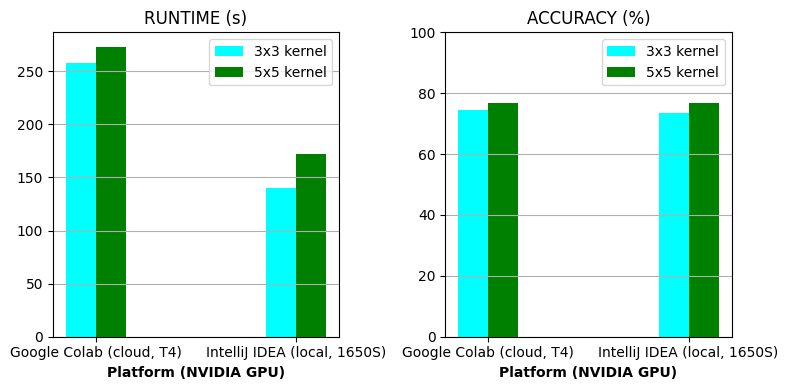

In [2]:
# 1
init = t.Compose([t.ToTensor(), t.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trn = torch.utils.data.DataLoader(CIFAR10(root = './Data', transform = init, download = True), batch_size = 32, shuffle = True)
tst = torch.utils.data.DataLoader(CIFAR10(root = './Data', train = False, transform = init, download = True), batch_size = 32)
# default params omitted; won't download if already in directory. REFERENCE [1][2]

# 2
class Net(nn.Module):
    def __init__(self, k):
        super(Net, self).__init__()
        self.c1 = nn.Conv2d(3, 32, k, padding = k // 2)
        self.b1 = nn.BatchNorm2d(32)   # no mention in instructions but neither prohibited; dramatically improved accuracy
        self.c2 = nn.Conv2d(32, 64, k, padding = k // 2)
        self.b2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.d1 = nn.Dropout(0.5)
        self.c3 = nn.Conv2d(64, 64, k, padding = k // 2)
        self.b3 = nn.BatchNorm2d(64)
        self.c4 = nn.Conv2d(64, 64, k, padding = k // 2)
        self.b4 = nn.BatchNorm2d(64)
        self.d2 = nn.Dropout(0.5)
        self.fc = nn.Linear(16384, 10)  # REFERENCE [3]
    def forward(self, a):
        a = self.b1(nn.ReLU()(self.c1(a)))  # <=> nn.functional.relu()
        a = self.b2(nn.ReLU()(self.c2(a)))
        a = self.d1(self.pool(a))
        a = self.b3(nn.ReLU()(self.c3(a)))
        a = self.b4(nn.ReLU()(self.c4(a)))
        return self.fc(self.d2(a).view(-1, 16384))

# 3
def training(k):
    processor = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # added for sake of compatibility (CREDIT: ChatGPT). remove if using Google Colab, and update all .to(processor) below
    num_epoch = 10
    start = time.time()
    mod = Net(k).to(processor)
    optimizer = torch.optim.SGD(mod.parameters(), lr = 0.002)  # Adam / RMSprop with 0.001 lr here can achieve 80%+ accuracy (same RT)
    criteria = nn.CrossEntropyLoss()
    progress = tqdm(total = num_epoch * len(trn), desc = "PROGRESS")

# 4
    for epoch in range(num_epoch):
        m = 0
        for _, (x, y) in enumerate(trn, 0):
            optimizer.zero_grad()
            loss = criteria(mod(x.to(processor)), y.to(processor))
            loss.backward()
            optimizer.step()
            m += loss.item()
            progress.update(1)
    mod.eval()
    count, total = 0, 0
    with torch.no_grad():
        for val in tst:
            label = val[1].to(processor)
            total += label.size(0)
            count += (torch.max(mod(val[0].to(processor)).data, 1)[1] == label).sum().item()
    progress.close()
    return round(time.time() - start, 2), 100 * count / total

time3, acc3 = training(3)
time5, acc5 = training(5)
print()
print(f"3x3 kernel Runtime: {time3} sec; Accuracy: {acc3}%\n5x5 kernel Runtime: {time5} sec; Accuracy: {acc5}%")
envs = ['Google Colab (cloud, T4)', 'IntelliJ IDEA (local, 1650S)']
data = {    ##
    'time': {envs[0]: {'3x3': 258, '5x5': 273}, envs[1]: {'3x3': time3, '5x5': time5}},
    'acc': {envs[0]: {'3x3': 74.61, '5x5': 76.85}, envs[1]: {'3x3': acc3, '5x5': acc5}}
}

b = 0.15     # bar width
r = np.arange(len(envs))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4))
for ax, (key, title, ylim) in zip([ax1, ax2], [('time', 'RUNTIME (s)', None), ('acc', 'ACCURACY (%)', (0, 100))]):
    for pos, ker, color in zip([r, r + b], data[key][envs[0]].keys(), ['cyan', 'green']):
        ax.bar(pos, [data[key][env][ker] for env in envs], width = b, color = color, label = f"{ker} kernel")
    ax.set_xlabel('Platform (NVIDIA GPU)', fontweight = 'bold')
    ax.set_xticks(r + b / 2)
    ax.set_xticklabels(envs)
    ax.set_title(title)
    ax.legend()
    ax.yaxis.grid(True)
    ax.set_ylim(ylim) if ylim else None
plt.tight_layout()
plt.show()

***Question 6 Answer***: The accuracies and runtimes are displayed above. Be advised that the runtime of Colab sheds no light on its actual capability since Tesla T4 doubles the CUDA cores of 1650 Super; CPU has also been tested, around 20 times slower on my machine.

Plausible factors affecting CNN performance:
1. kernel size (the only variable that we checked explicitly): 3x3 kernel captures finer details; 5x5 captures broader features but proves computationally costlier;
2. depth: a deeper / wider network (more filters) captures complex features and thus higher accuracy (but may overfit and requires more data);
3. batch size: influencing training speed and stability;
4. strides & padding: affecting output size and feature capturing;
5. initialization & regularization: affecting training speed and overfitting;
6. learning rate & optimizer: affecting the rate and training stability.

We conclude that a larger kernel can slightly improve the accuracy but seems <u>**unworthy compared to its increase in runtime**</u>. Also, differences in accuracy between environments (Colab vs local) could be due to factors like operating system or training variability. In general, the optimal settings depend on our available resources and probably can only become confident after trying out some combinations with patience.

\
#**Part 2 YOLO Object Detection on Montréal Streets** REFERENCE [4]

Categories    | Quantity
------------------------
car           | 9       
person        | 14      
traffic light | 6       
handbag       | 1       


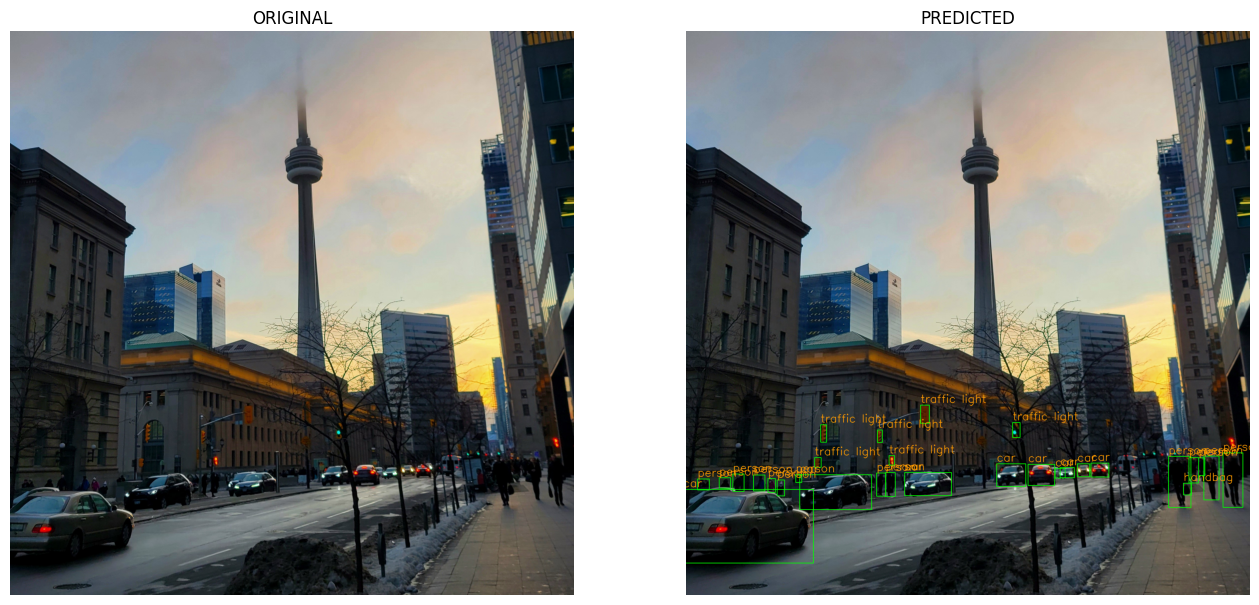

In [9]:
net = cv2.dnn.readNet(PATH + "yolov3.weights", PATH + "yolov3.cfg") ## loading the pre-trained model
cls = open(PATH + "coco.names", "r").read().splitlines()            ## which YOLO was trained on. REFERENCE [5]
img = cv2.imread(PATH + 'toronto.jpg')                              ## image to be processed

box, confidence, classID = [], [], []
h, w, _ = img.shape
obj = {}
net.setInput(cv2.dnn.blobFromImage(img, 1 / 255, (608, 608), (0, 0, 0), swapRB = True, crop = True))
for outputs in net.forward(net.getUnconnectedOutLayersNames()):
    for output in outputs:
        score = output[5:]
        id = np.argmax(score)
        certainty = score[id]
        if certainty > 0.3:    # confidence threshold, adjust with Non-Max Suppression params together
            h1 = int(output[3] * h)
            w1 = int(output[2] * w)
            h0 = int(int(output[1] * h) - h1 / 2)
            w0 = int(int(output[0] * w) - w1 / 2)
            box.append([w0, h0, w1, h1])
            confidence.append(float(certainty))
            classID.append(id)
for i in cv2.dnn.NMSBoxes(box, confidence, 0.2, 0.3):  # avoiding overlapping boxes
    lbl = cls[classID[i]]
    obj[lbl] = obj.get(lbl, 0) + 1
    w0, h0, w1, h1 = box[i]
    cv2.rectangle(img, (w0, h0), (w0 + w1, h0 + h1), (0, 255, 0), 2)
    cv2.putText(img, lbl, (w0, h0 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 155, 255), 2)

# 3. Results Table
max_len = max(len(object_name) for object_name in obj)
pattern = "{:<{width}} | {:<8}"
print(pattern.format("Categories", "Quantity", width = max_len) + "\n" + "-" * (max_len + 11))
for name, number in obj.items():
    print(pattern.format(name, number, width = max_len))

# 4. Images Comparison
fig, ax = plt.subplots(1, 2, figsize = (16, 12))
ax[0].imshow(cv2.cvtColor(cv2.imread(PATH + 'toronto.jpg'), cv2.COLOR_BGR2RGB)) ##
ax[0].set_title("ORIGINAL")
ax[0].axis("off")
ax[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[1].set_title("PREDICTED")
ax[1].axis("off")
plt.show()

## References

1. **Pytorch**. (n.d.). *vision/torchvision/datasets/cifar.py at main*.
    - [GitHub](https://github.com/pytorch/vision/blob/main/torchvision/datasets/cifar.py)
    - Accessed 2023/10/31
2. **torch.utils.data — PyTorch 2.1 documentation**. (n.d.).
    - [PyTorch Documentation](https://pytorch.org/docs/stable/data.html)
    - Accessed 2023/10/31
3. **Neural Networks — PyTorch Tutorials 2.1.0+cu121 documentation**. (n.d.).
    - [PyTorch Tutorials](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html)
    - Accessed 2023/10/29
4. **Redmon, J.** (n.d.). *YOLO: Real-Time Object Detection*.
    - [pjreddie.com](https://pjreddie.com/darknet/yolo/)
    - Accessed 2023/11/01
5. **Pjreddie**. (n.d.). *GitHub - pjreddie/darknet: Convolutional Neural Networks*.
    - [GitHub](https://github.com/pjreddie/darknet/blob/master/)
    - Accessed 2023/10/29